<a href="https://colab.research.google.com/github/Habibu-Ahmad/Physics-Informed-Neural-Network/blob/main/Burgers_Eqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Imports**

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc
import time

tf.keras.backend.set_floatx("float64")

**2. PINN Class Definition**

In [9]:

class BurgersPINN:
    def __init__(self, neuron_per_layer=20, actfn="tanh"):
        self.neuron_per_layer = neuron_per_layer
        self.actfn = actfn
        self.model = self.build_model()
        self.loss_history = []

    def build_model(self):
        inputs = tf.keras.Input(shape=(2,))
        x = inputs
        for _ in range(9):
            x = tf.keras.layers.Dense(self.neuron_per_layer)(x)
            x = tf.keras.layers.Activation(self.actfn)(x)
        outputs = tf.keras.layers.Dense(1)(x)
        return tf.keras.Model(inputs, outputs)

    @tf.function
    def u(self, t, x, training=True):
        return self.model(tf.concat([t, x], axis=1), training=training)

    @tf.function
    def physics_loss(self, t, x):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([t, x])
            u0 = self.u(t, x, training=True)
            u_t = tape.gradient(u0, t)
            u_x = tape.gradient(u0, x)
        u_xx = tape.gradient(u_x, x)
        del tape
        nu = 0.01 / np.pi
        F = u_t + u0 * u_x - nu * u_xx
        return tf.reduce_mean(tf.square(F))

    @staticmethod
    @tf.function
    def mse(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    def train(self, t_d, x_d, y_d, t_c, x_c, epochs=2000, lr=5e-4):
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        start = time.time()

        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                y_pred = self.u(t_d, x_d, training=True)
                L_phys = self.physics_loss(t_c, x_c)
                L_data = self.mse(y_d, y_pred)
                loss = L_phys + L_data

            grads = tape.gradient(loss, self.model.trainable_weights)
            opt.apply_gradients(zip(grads, self.model.trainable_weights))
            self.loss_history.append(loss.numpy())

            if epoch % 100 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch:4d} | Loss: {loss.numpy():.6f}")

        duration = time.time() - start
        print(f"Training Time: {duration:.2f} seconds")
        return self.loss_history

    def evaluate(self):
        n, m = 100, 200
        X = np.linspace(-1, +1, m)
        T = np.linspace(0, 1, n)
        X0, T0 = np.meshgrid(X, T)
        X = X0.reshape([n * m, 1])
        T = T0.reshape([n * m, 1])
        X_tf = tf.convert_to_tensor(X)
        T_tf = tf.convert_to_tensor(T)

        U = self.u(T_tf, X_tf, training=False)
        U = U.numpy().reshape(n, m)

        plt.figure(figsize=(8, 3), dpi=150)  # Wider aspect ratio for 2D plots
        plt.pcolormesh(T0, X0, U, cmap=cm.rainbow, shading='auto')
        cbar = plt.colorbar(pad=0.02, aspect=30)  # Adjust colorbar
        cbar.ax.tick_params(labelsize=8)
        plt.title("u(x, t)", fontsize=10)
        plt.xlabel("t", fontsize=9)
        plt.ylabel("x", fontsize=9)
        plt.tick_params(axis='both', labelsize=8)
        plt.tight_layout()
        plt.show()
        return U

    def plot_snapshots(self):
        x = np.linspace(-1, +1, 200)
        t_vals = [0.25, 0.5, 0.75]

        plt.figure(figsize=(6, 4), dpi=150)  # Balanced aspect ratio
        for t in t_vals:
           u_val = self.u(tf.convert_to_tensor(np.full_like(x, t)[:, None]),
                  tf.convert_to_tensor(x[:, None]),
                  training=False)
           plt.plot(x, u_val, label=f"t={t}", lw=1.5)

        plt.title("Temporal Snapshots", fontsize=10)
        plt.xlabel("Space (x)", fontsize=9)
        plt.ylabel("u(x,t)", fontsize=9)
        plt.legend(fontsize=8, framealpha=1.0, loc='best')
        plt.grid(True, alpha=0.3)
        plt.tick_params(axis='both', labelsize=8)
        plt.tight_layout(pad=1.5)  # Slightly more padding
        plt.show()

**3. Data Generation**

In [10]:

def generate_data():
    number_of_ic_points = 50
    number_of_bc1_points = 25
    number_of_bc2_points = 25

    # Time points
    engine = qmc.LatinHypercube(d=1)
    t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
    t_d = np.append(np.zeros([number_of_ic_points, 1]), t_d, axis=0)

    # Space points
    x_d = engine.random(n=number_of_ic_points)
    x_d = 2 * (x_d - 0.5)
    x_d = np.append(x_d, -1 * np.ones([number_of_bc1_points, 1]), axis=0)
    x_d = np.append(x_d, +1 * np.ones([number_of_bc2_points, 1]), axis=0)

    # Boundary and Initial conditions
    y_d = np.zeros(x_d.shape)
    y_d[:number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

    # Collocation points
    Nc = 10000
    engine = qmc.LatinHypercube(d=2)
    data = engine.random(n=Nc)
    data[:, 1] = 2 * (data[:, 1] - 0.5)

    t_c = np.expand_dims(data[:, 0], axis=1)
    x_c = np.expand_dims(data[:, 1], axis=1)

    # Convert to tensors
    return map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

x_d, t_d, y_d, x_c, t_c = generate_data()

**4. Training**

In [11]:

pinn = BurgersPINN()
loss_history = pinn.train(t_d, x_d, y_d, t_c, x_c)

Epoch    0 | Loss: 0.258177
Epoch  100 | Loss: 0.115086
Epoch  200 | Loss: 0.098199
Epoch  300 | Loss: 0.090064
Epoch  400 | Loss: 0.081935
Epoch  500 | Loss: 0.073496
Epoch  600 | Loss: 0.067565
Epoch  700 | Loss: 0.063325
Epoch  800 | Loss: 0.057977
Epoch  900 | Loss: 0.052319
Epoch 1000 | Loss: 0.048034
Epoch 1100 | Loss: 0.038244
Epoch 1200 | Loss: 0.028891
Epoch 1300 | Loss: 0.024451
Epoch 1400 | Loss: 0.021637
Epoch 1500 | Loss: 0.019802
Epoch 1600 | Loss: 0.017446
Epoch 1700 | Loss: 0.016961
Epoch 1800 | Loss: 0.015178
Epoch 1900 | Loss: 0.014953
Epoch 1999 | Loss: 0.013618
Training Time: 1097.03 seconds


**5. Plot loss history**

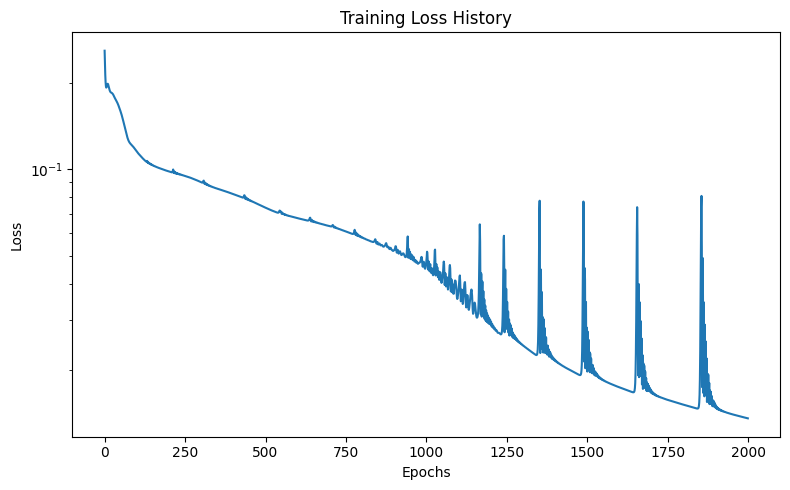

In [12]:

plt.figure(figsize=(8, 5))
plt.semilogy(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.tight_layout()
plt.show()

**6. Evaluation**

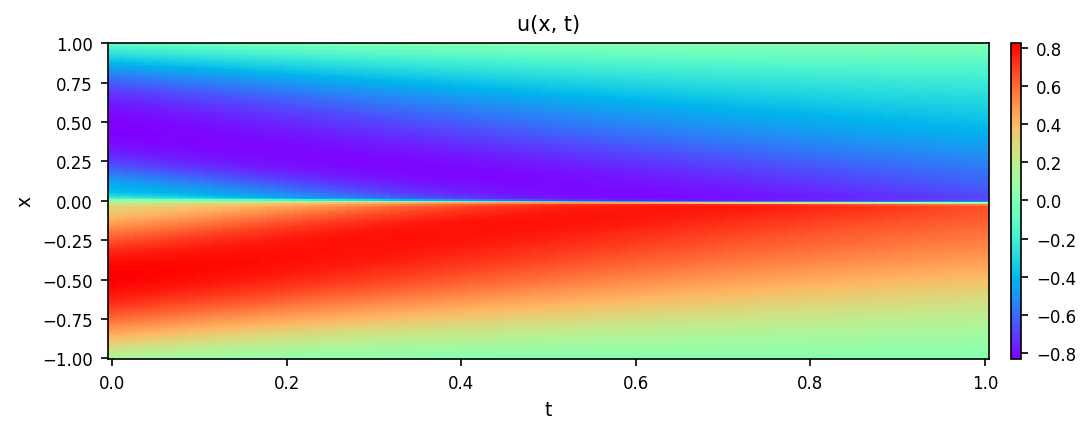

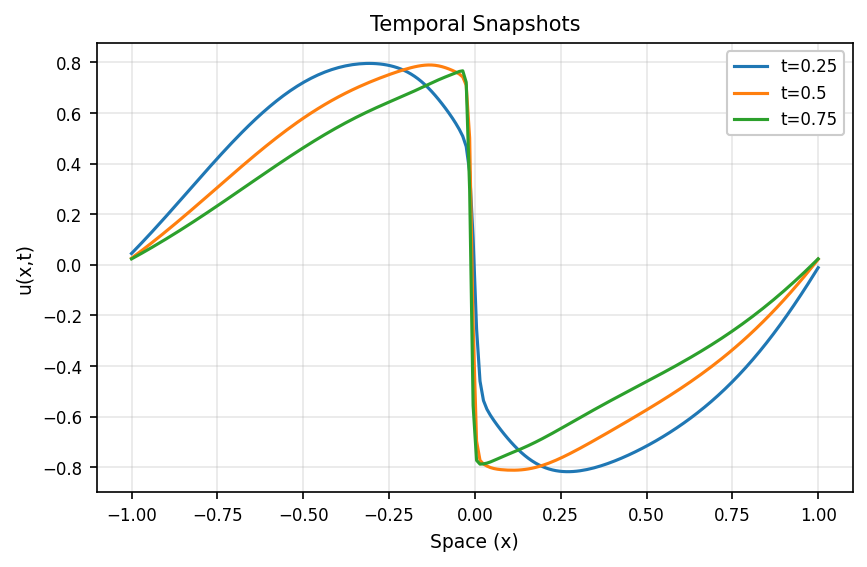

In [13]:
# Evaluate and plot results
u_pred = pinn.evaluate()
pinn.plot_snapshots()

**7. Detailed Predictions**

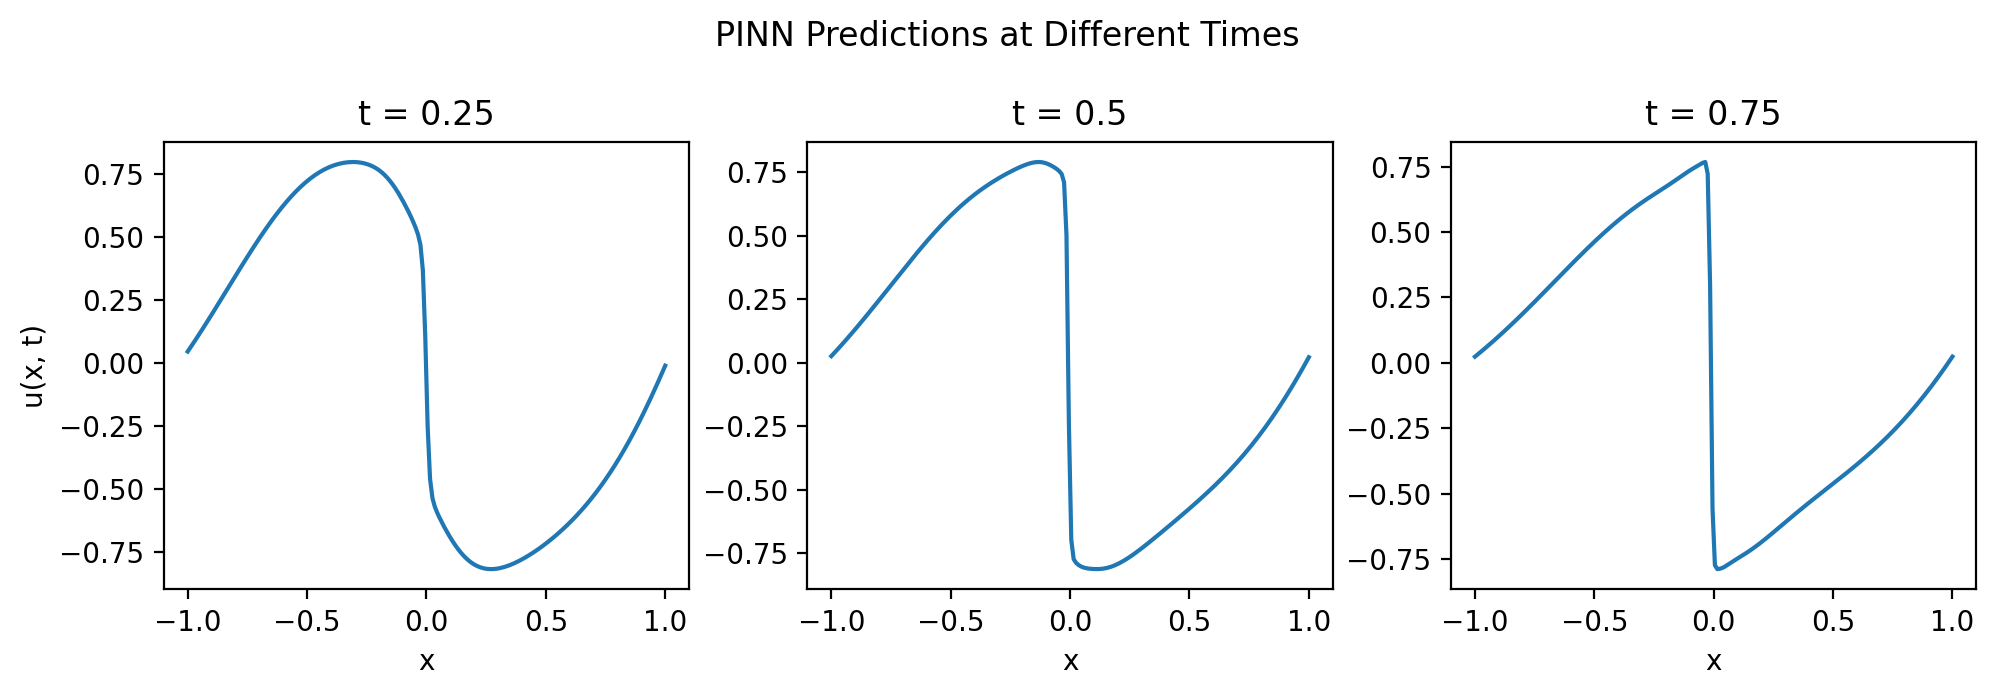

In [14]:

x = np.linspace(-1, +1, 200).reshape(-1, 1)
t_vals = [0.25, 0.5, 0.75]

plt.figure(figsize=(10, 3.5), dpi=200)

for i, t_val in enumerate(t_vals):
    t_input = tf.convert_to_tensor(np.full_like(x, t_val))
    x_input = tf.convert_to_tensor(x)

    u_pred = pinn.u(t_input, x_input, training=False).numpy()

    plt.subplot(1, 3, i + 1)
    plt.plot(x, u_pred, lw=1.5)
    plt.title(f"t = {t_val}")
    plt.xlabel("x")
    if i == 0:
        plt.ylabel("u(x, t)")

plt.suptitle("PINN Predictions at Different Times")
plt.tight_layout()
plt.show()